# AGRUPAMIENTO CONOCIDO

Para la primera parte de la actividad, en la que se analizará un conjunto de datos con agrupamiento conocido, se ha decidido utilizar uno de los datasets sintéticos proporcionados. El objetivo principal será el demostrar, aprovechando las particularidades tan marcadas del dataset, como la tipología de los datos afecta a la efectividad de los distintos métodos de agrupamiento.<br>

En el caso del dataset escogido "dataset_cuatro_diferente_densidad" la particularidad más marcada es la diferencia de densidades entre los distintos agrupamientos, lo que, como se podrá comprobar, pondrá en serias dificultades algunos de los algoritmos analizados. Si se hubieran escogido otros datos, los resultados habrían variado significativamente.

In [ ]:
# Se importan las distintas librerías que se usarán durante la actividad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# Se declaran un grupo de funciones de evaluación intrínsecas que se utilizaran más adelante
def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

def medida_entropia(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    relMat = mat/np.sum(mat,0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat==0]=0.0001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([totales[k] * np.sum([relMat[l,k]*logRelMat[l,k] 
                                         for l in np.arange(mat.shape[0])]) 
                    for k in np.arange(mat.shape[1])])

# Se declara la función que se utilizará para comprobar los resultados de los distintos agrupamientos 
def intrinsic_evaluation(Dy_t, Dy_p):
    conf_matrix = confusion_matrix(Dy_t, Dy_p)
    entropy = medida_entropia(conf_matrix)
    purity = medida_pureza(conf_matrix)
    f1 = medida_f1(conf_matrix)
    df_cm = pd.DataFrame(conf_matrix)
    plt.figure(figsize = (10,7))
    plt.title('Pureza: '  + str(round(purity, 4)) + '  F1: ' + str(round(f1, 4)) + '  Entropía: ' + str(round(entropy, 4)),
              fontdict={'fontsize':20})
    sn.heatmap(df_cm, annot=True, cmap="Blues")

# k-means++

Como representante de agrupamiento basado en particiones se ha escogido **k-means++**, máximo representante de este tipo de agrupamiento y del clustering en general (con sus variaciones).

El dataset cargado tiene 3998 instancias.


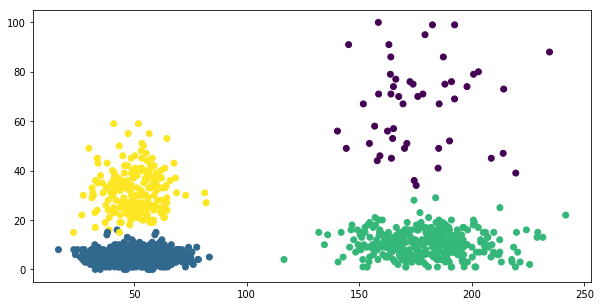

In [39]:
# Si se quiere asegurar la reproducibilidad de la práctica se fija la semilla aleatoria
# Sin embargo, si lo que se busca es simular una situación real puede ser más interesante evaluar múltiples casuísticas con
# inicializaciones distintas.
np.random.seed(17)

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
Dx = D[:,0:2]
Dy = D[:,2]

print('El dataset cargado tiene',Dx.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

*El primer paso que se realizará es la detección del número óptimo de clusters. Para ello se utilizarán dos medidas de evaluación intrínseca (ancho de silueta y índice de Calinski-Harabasz) y el procedimiento del codo.*

Text(0, 0.5, 'Medida de Calinski-Harabasz')

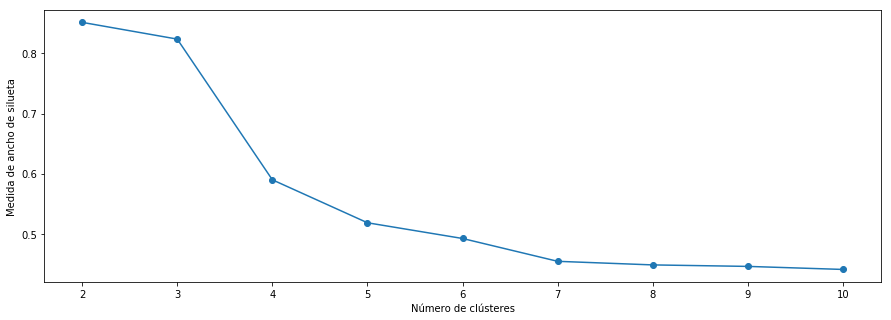

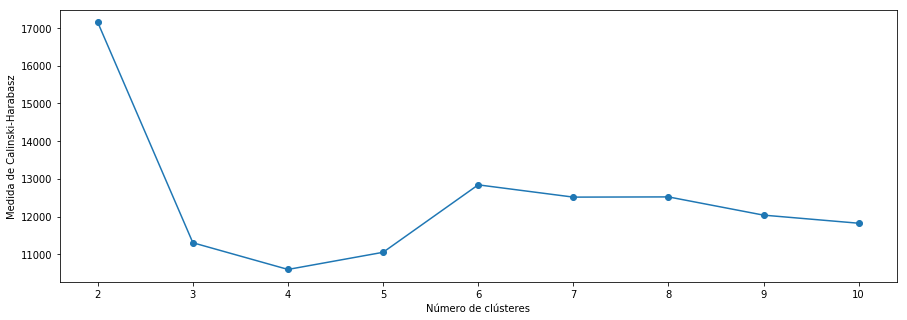

In [40]:
# Compruebo que 4 es un buen número de clústers
from sklearn.metrics import silhouette_score, calinski_harabaz_score

rsilueta = np.zeros(9)
rcalinski = np.zeros(9)

for k in np.arange(2,11):
    modelo = KMeans(n_clusters=k, init='k-means++')
    modelo = modelo.fit(Dx)
    Dyp_sk = modelo.predict(Dx)
    cDx_sk = modelo.cluster_centers_
    rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
    rcalinski[k-2] = calinski_harabaz_score(Dx, Dyp_sk)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11), rsilueta, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Medida de ancho de silueta")

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11), rcalinski, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Medida de Calinski-Harabasz")

*Si se observan las medidas de ancho de silueta para las distintas cantidades de clusters se puede ver el cambio de pendiente anunciado por la regla del codo en k=4. A su vez, la mejor medida de Calinski-Harabasz también se encuentra en k=4 por lo que se escoge este número de clusters.*

In [41]:
# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=4, init='k-means++')
# Se aprende el 
modelo = modelo.fit(Dx)
# Se predicen los clusters
Dyp_sk = modelo.predict(Dx)
# Se obtienen los centros de los clústeres
cDx_sk = modelo.cluster_centers_

In [42]:
# Los centros de los clusters se encuentran en
print(cDx_sk)

[[ 50.78213592  32.0776699 ]
 [179.3065043   10.59025788]
 [ 50.24671674   5.20600858]
 [175.6826087   68.36956522]]


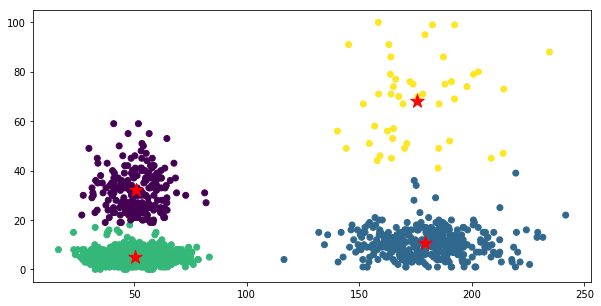

In [43]:
# Se muestra el resultado de las asignaciones finales
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')

*Finalmente se aplican las distintas medidas intrínsecas para evaluar el comportamiento del algoritmo.*

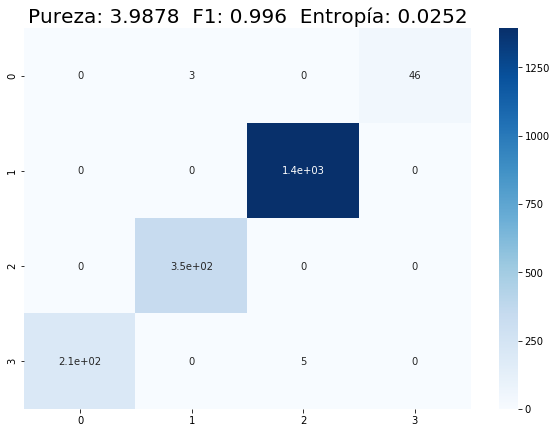

In [84]:
# Debido a que los valores de los clusteres reales van de 1 a 4 y que los calculados van de 0 a 3,
# se aplica un factor de corrección para calcular la matriz de confusión.
intrinsic_evaluation(Dy-[1], Dyp_sk)

# Clustering Jerárquico Aglomerativo

Como ejemplo de agrupamiento jerárquico se utilizará la aproximación aglomerativa debido a que hasta el momento la divisiva raramente se utiliza en aplicaciones reales.

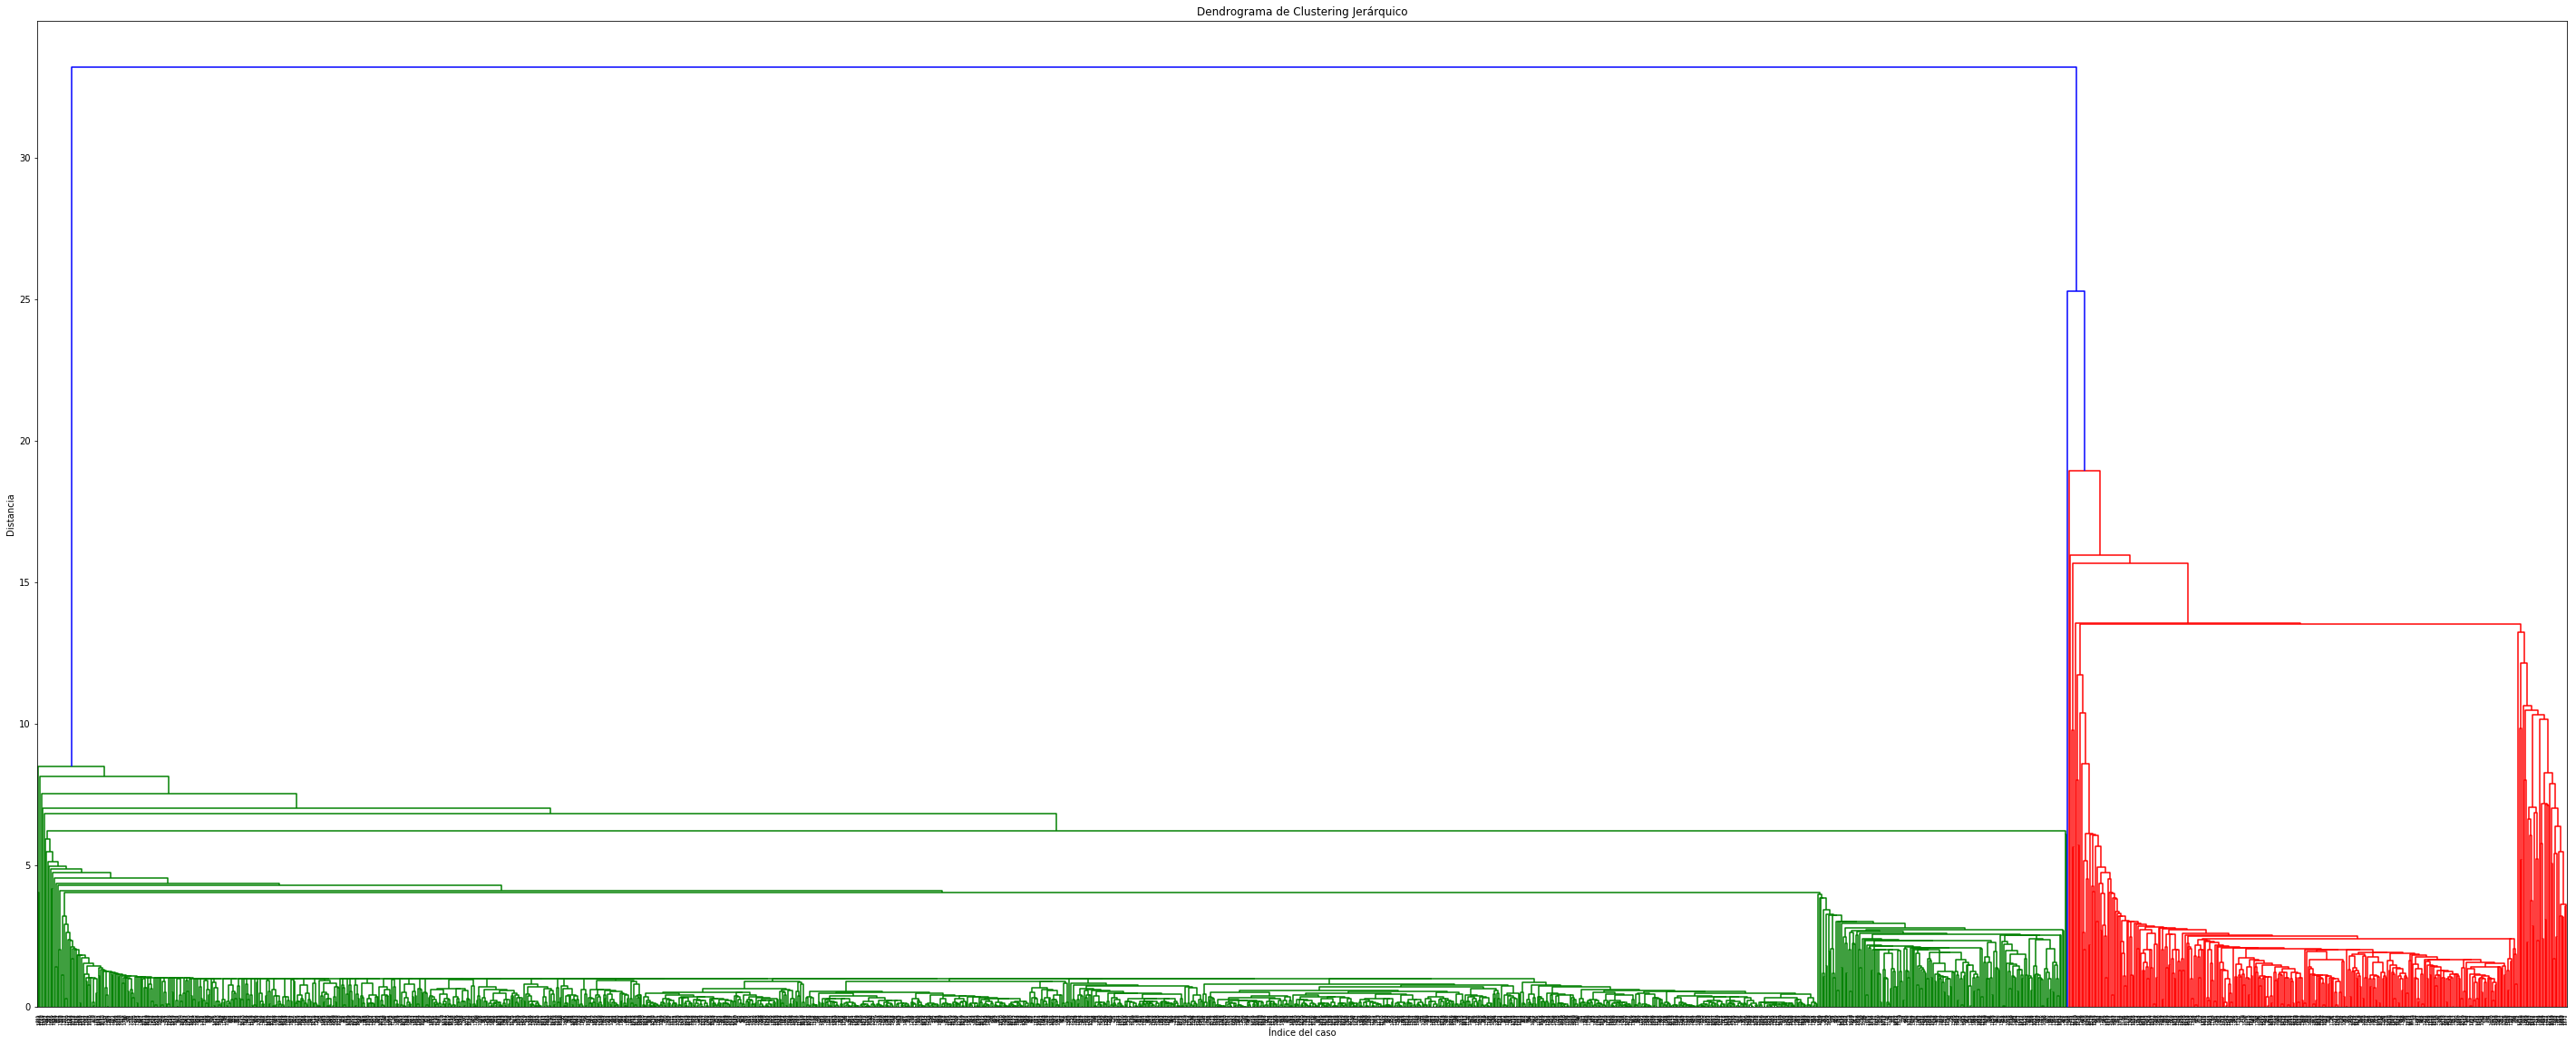

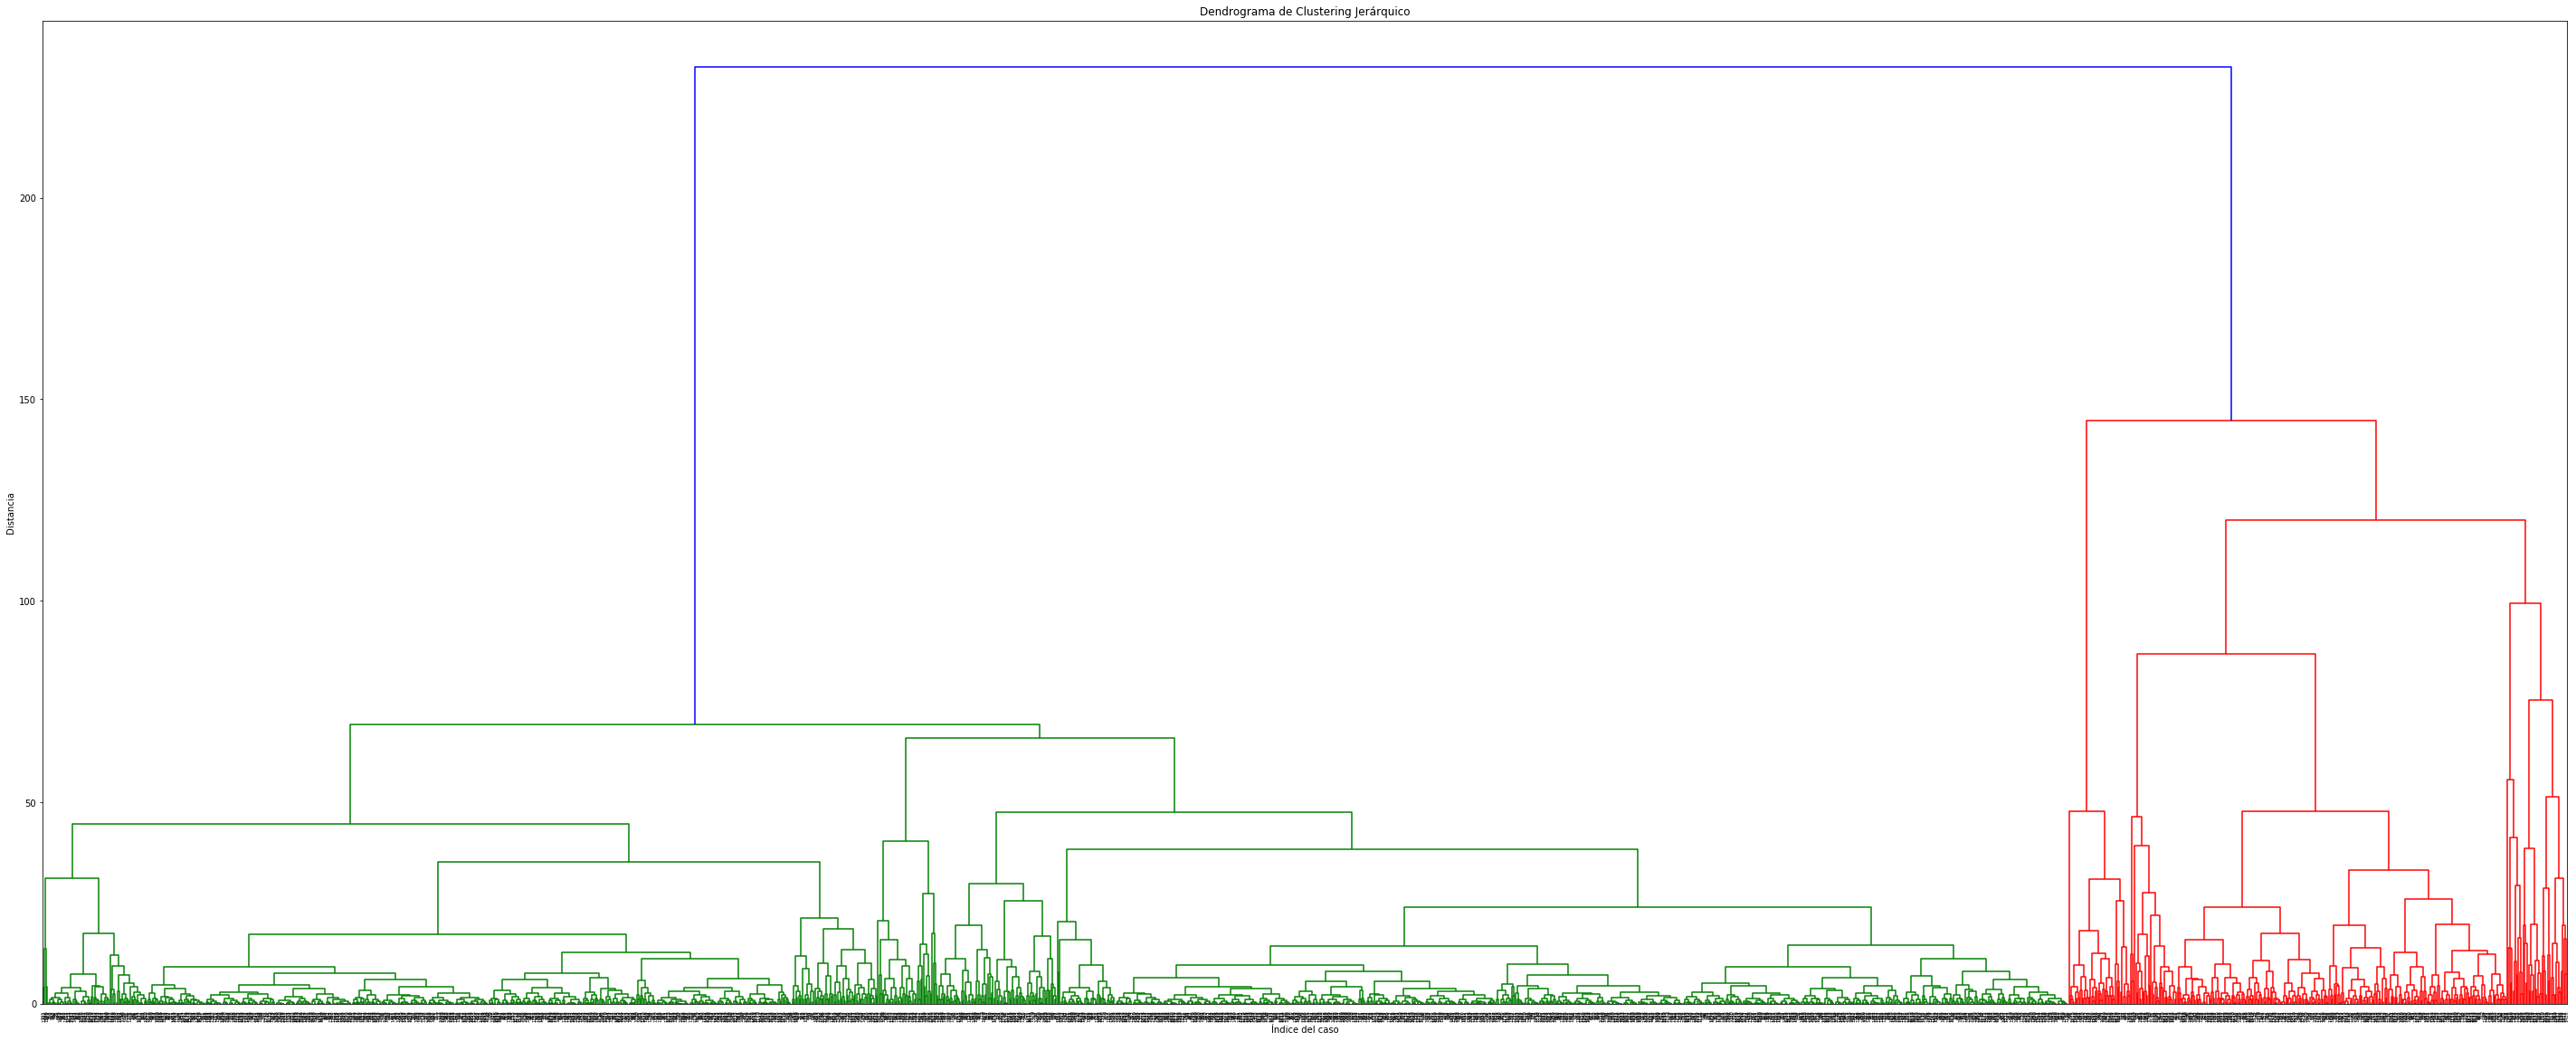

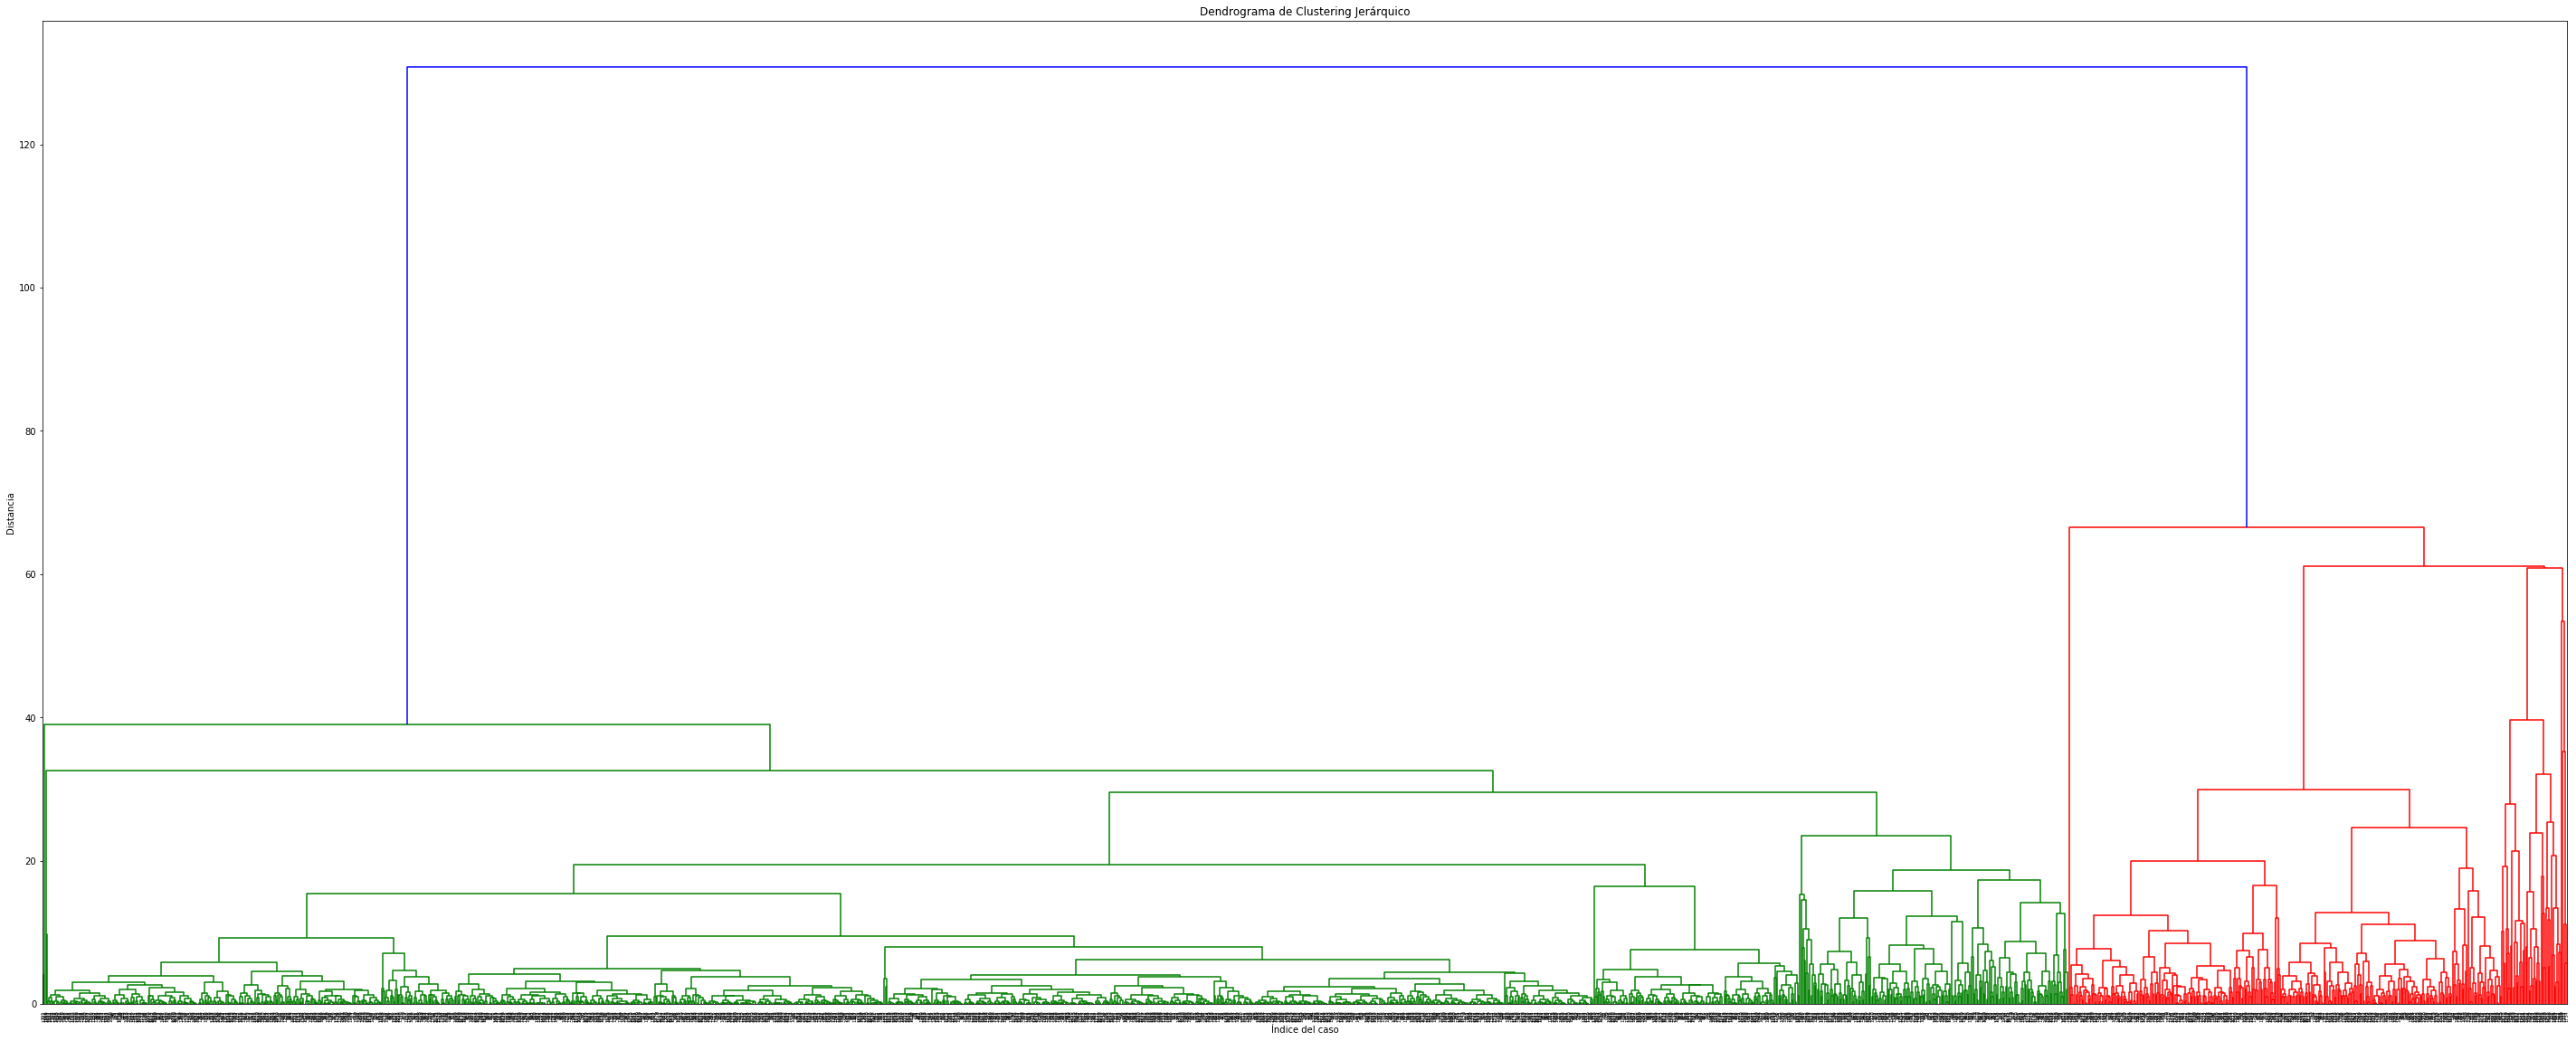

In [65]:
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree, dendrogram

# Se generan 3 modelos utilizando los distintos tipos de cálculo de disimilitud intercluster estudiados en clase
modelo_single = linkage(Dx, 'single')   # disimilitud mínima
modelo_completo = linkage(Dx, 'complete') # disimilitud máxima
modelo_average = linkage(Dx, 'average')  # disimilitud media

plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_single)
plt.show()

plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_completo)
plt.show()

plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_average)
plt.show()

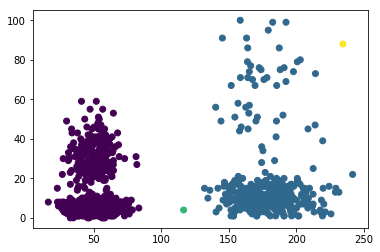

In [66]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo_single, n_clusters=4).flatten())
plt.show() # No funciona muy bien. Los puntos amarillo y verde los considera un clúster y no logra separar.

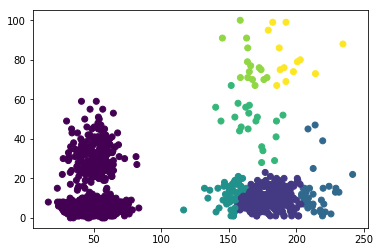

In [70]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo_completo, n_clusters=4).flatten())
plt.show() # No funciona muy bien. 

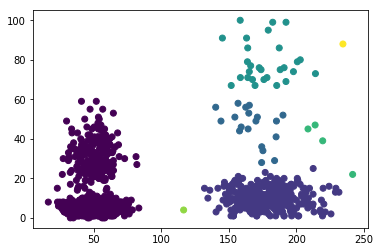

In [73]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo_average, n_clusters=4).flatten())
plt.show() # No funciona muy bien. El punto amarillo lo considera un clúster y no logra separar el de la izquierda

In [78]:
# La siguiente función llega a los mismos resultados 
def plot_varios(Dx,Dy,K):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax[0].scatter(Dx[:,0], Dx[:,1], c=Dy)
    ax[0].set_title('Datos originales')

    modelo = linkage(Dx, 'single')
    ax[1].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[1].set_title('Disimilitud mínima')
    
    modelo = linkage(Dx, 'complete')
    ax[2].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[2].set_title('Disimilitud máxima')
    
    modelo = linkage(Dx, 'average')
    ax[3].scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo, n_clusters = K).flatten())
    ax[3].set_title('Disimilitud media')

[0 0 1 ... 1 0 0]


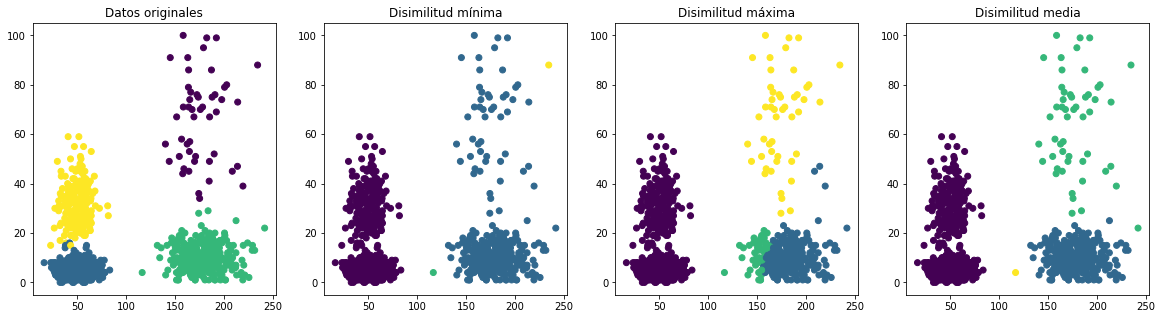

In [76]:
plot_varios(Dx,Dy,4) # Ninguna distancia funciona muy bien

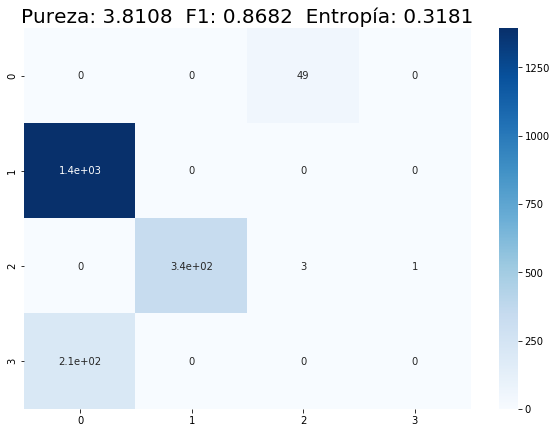

In [85]:
# Se utiliza el modelo que ha devuelto mejores resultados (modelo_average) para la evaluación intrínseca. 
intrinsic_evaluation(Dy-[1], cut_tree(modelo_average, n_clusters=4).flatten())

# Agrupamiento Espectral

Como caso paradigmático de agrupamiento espectral se utilizará un grafo con K vecinos más cercanos y una laplaciana normalizada (utilizada en la función SpectralClustering de sklearn).<br>

Para empezar, buscamos el número óptimo de vecinos para el KNN.

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\lib

Text(0, 0.5, 'Medida de Calinski-Harabasz')

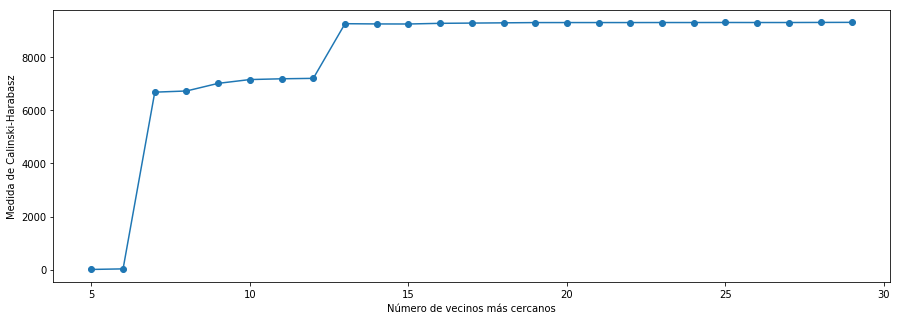

In [106]:
from sklearn.cluster import SpectralClustering
K = 4

rcalinski = np.zeros(25)

for knn in np.arange(5,30):
    modelo = SpectralClustering(n_clusters = K, 
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0)
    Dyp_sk = modelo.fit_predict(Dx)
    rcalinski[knn-5] = calinski_harabaz_score(Dx, Dyp_sk)
    
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(5,30), rcalinski, linestyle='-', marker='o')
ax.set_xlabel("Número de vecinos más cercanos")
ax.set_ylabel("Medida de Calinski-Harabasz")

*Se observa que para pocos vecinos el algoritmo no es capaz de crear un grafo totalmente conectado.<br>
También se ve que de 13 vecinos en adelante, el algoritmo no mejora*

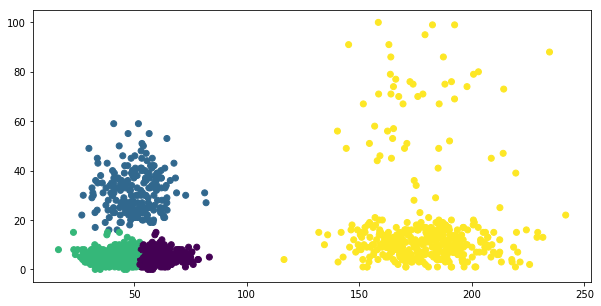

In [107]:
from sklearn.cluster import SpectralClustering
K = 4
knn = 15 # No es capaz de resolver al probar distintos valores de knn
clustering = SpectralClustering(n_clusters = K, 
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

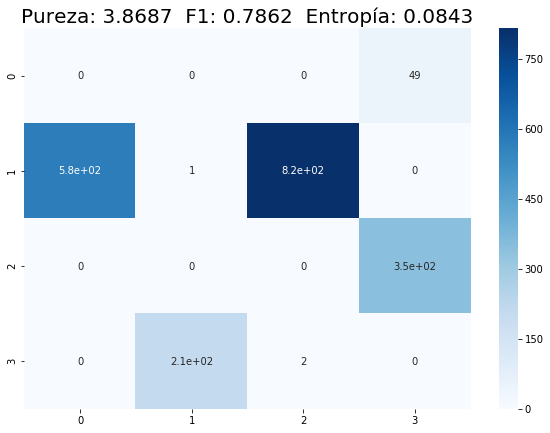

In [108]:
# Se utiliza el modelo con K=4 y knn=15 visto arriba
intrinsic_evaluation(Dy-[1], clustering.fit_predict(Dx).flatten())

# Agrupamiento basado en densidad - DBSCAN

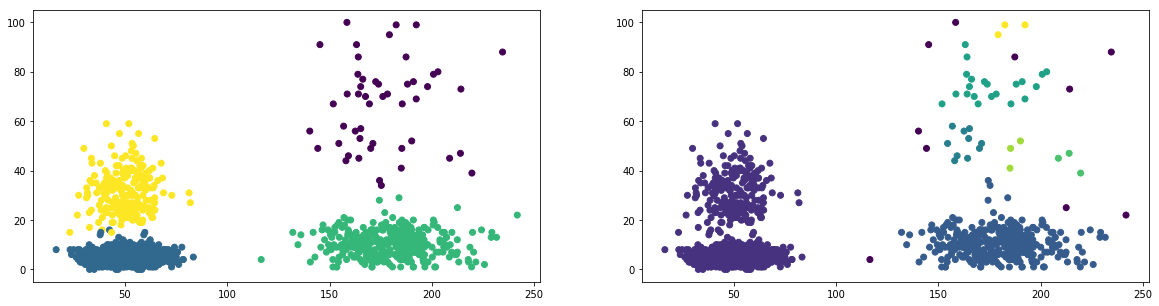

In [14]:
# No funciona bien para este tipo de datos

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

eps = 10
M = 3

clustering = DBSCAN(eps=eps, min_samples=M).fit(Dx)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c= Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = clustering.labels_)

# Agrupamiento basado en densidad - Mean Shift

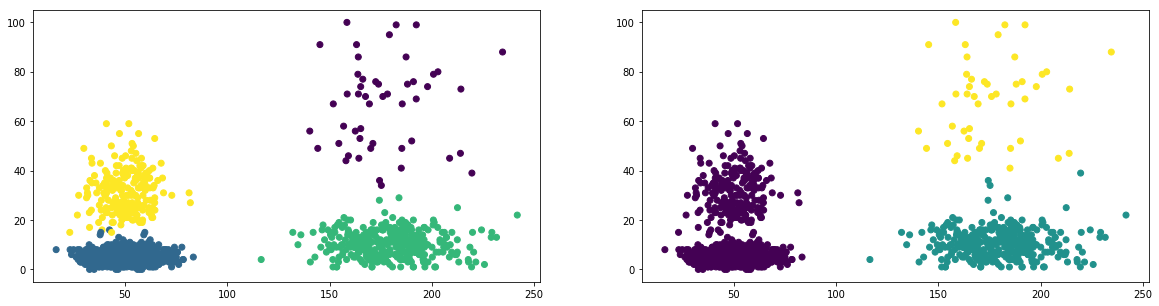

In [15]:
# Variando h (bandwidth) solo consigue separar en 3 clusters, no 4
from sklearn.cluster import MeanShift

clustering = MeanShift(bandwidth = 40).fit(Dx)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = clustering.labels_)

# Agrupamiento basado en densidad - Affinity Propagation

In [16]:
# He tenido que pasar un buen rato modificando el factor de aprendizaje y las preferencias hasta obtener 4 clusters

from sklearn.metrics.pairwise import euclidean_distances

mSimilitud = euclidean_distances(Dx)
mSimilitud = -mSimilitud**2

preferencia = np.median(mSimilitud) * 155 # importancia de las preferencias 
np.fill_diagonal(mSimilitud, preferencia)

factor = 0.95 # factor de aprendizaje (entre 0 y 1)

In [17]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(preference=preferencia, damping=factor).fit(Dx)

In [18]:
def dibujar_clusteringAP(modelo):
    fig = plt.figure(figsize=(10, 5))

    ncentros = modelo.cluster_centers_indices_.size
    colores = 'bgrcmyk'

    for k in np.arange(ncentros):
        kc = k % len(colores)

        centro = Dx[modelo.cluster_centers_indices_[k],:]
        miembros_cluster = np.where(modelo.labels_ == k)[0]

        plt.scatter(Dx[miembros_cluster, 0], Dx[miembros_cluster, 1], c=colores[kc], s=3)
        for i in miembros_cluster:
            plt.plot([centro[0], Dx[i,0]], [centro[1], Dx[i,1]], c = colores[kc])

    plt.scatter(Dx[modelo.cluster_centers_indices_,0], Dx[modelo.cluster_centers_indices_,1], 
                s=50, c = 'black')

    plt.title('Núm. clústeres: %s' % ncentros)
    plt.show()

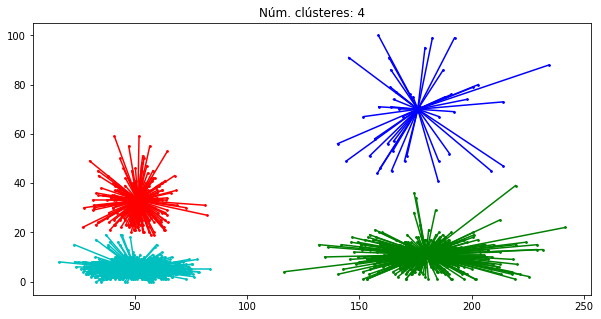

In [19]:
dibujar_clusteringAP(clustering)

# Mixtura de Gaussianas y algoritmo EM

In [20]:
from sklearn.mixture import GaussianMixture

def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)


def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 4, max_iter = 200)
# Se aprende el modelo
modelo = modelo.fit(Dx)
# Se predicen las asignaciones a clústeres
Dyp_sk = modelo.predict(Dx)

# Medimos el rendimiento del algoritmo de ScikitLearn
mC_sk = matriz_confusion(Dy,Dyp_sk)

print('Matriz de confusión:')
print(mC_sk)
print('El valor del error cometido es = ', medida_error(mC_sk))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC_sk))
print('El valor F1 es = ', medida_f1(mC_sk))


Matriz de confusión:
[[   0    0   49    0]
 [1385    0    0    8]
 [   0  344    2    0]
 [   0    0    0  211]]
El valor del error cometido es =  0.005002501250625291
La pureza del agrupamiento obtenido es =  0.9949974987493748
El valor F1 es =  0.99503751924735


Text(0.5,1,'Algoritmo EM')

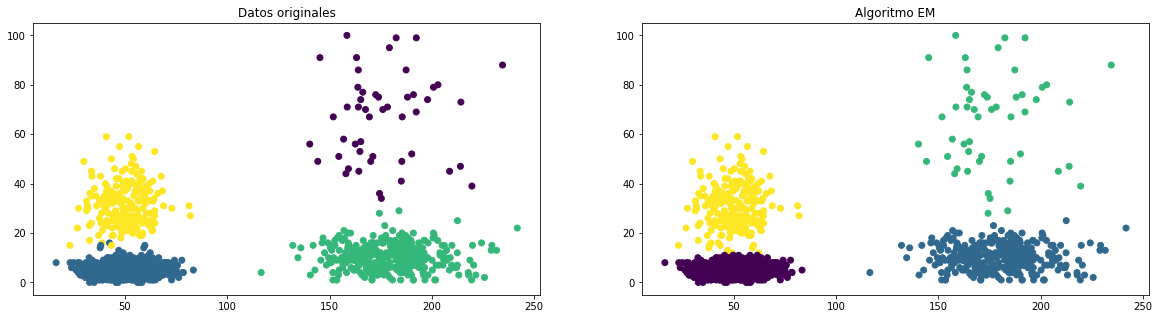

In [21]:
# Mostrar resultados. Parece funcionar bien, pero hay algunos puntos que no se asignan correctamente
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax[0].set_title('Datos originales')
ax[1].set_title('Algoritmo EM')

# AGRUPAMIENTO NO CONOCIDO

In [110]:
import io
import requests
from pprint import pprint

# DATASET DE AUTOS_MPG DE UCI
url_autos = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
data_names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name']

response=requests.get(url_autos).content
ds_autos=pd.read_csv(io.StringIO(response.decode('utf-8')),delim_whitespace=True,header=None, names = data_names,na_values='?')

# Limpieza de las instancias con valores nulos
ds_autos = ds_autos.dropna()

# EJEMPLO DE DATOS
ds_autos.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
79,26.0,4,96.0,69.0,2189.0,18.0,72,2,renault 12 (sw)
80,22.0,4,122.0,86.0,2395.0,16.0,72,1,ford pinto (sw)
35,17.0,6,250.0,100.0,3329.0,15.5,71,1,chevrolet chevelle malibu
310,38.1,4,89.0,60.0,1968.0,18.8,80,3,toyota corolla tercel
241,22.0,6,146.0,97.0,2815.0,14.5,77,3,datsun 810


In [111]:
# ESTADÍSTICA DEL DATASET
ds_autos.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [112]:
# Correlación entre las columnas
ds_autos.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
model year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [113]:
# Transformación a array de numpy eliminando el modelo del coche
D = np.array(ds_autos)[:,:-1]

# Guardamos los nombres de las columnas
columHeaders = ds_autos.columns.values[:-1]

D

array([[18.0, 8, 307.0, ..., 12.0, 70, 1],
       [15.0, 8, 350.0, ..., 11.5, 70, 1],
       [18.0, 8, 318.0, ..., 11.0, 70, 1],
       ...,
       [32.0, 4, 135.0, ..., 11.6, 82, 1],
       [28.0, 4, 120.0, ..., 18.6, 82, 1],
       [31.0, 4, 119.0, ..., 19.4, 82, 1]], dtype=object)

## K-means++

Text(0, 0.5, 'Medida de Calinski-Harabasz')

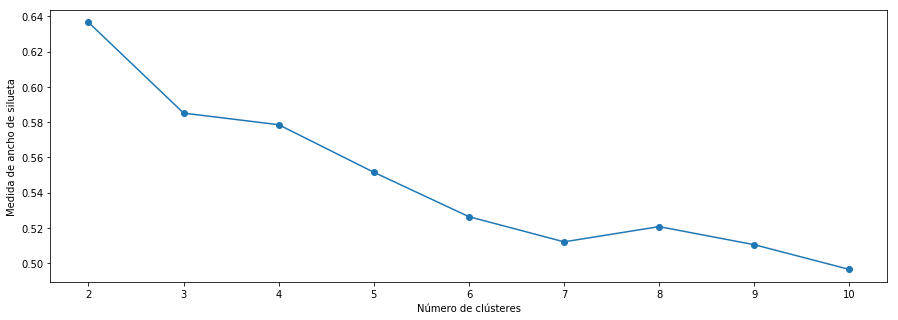

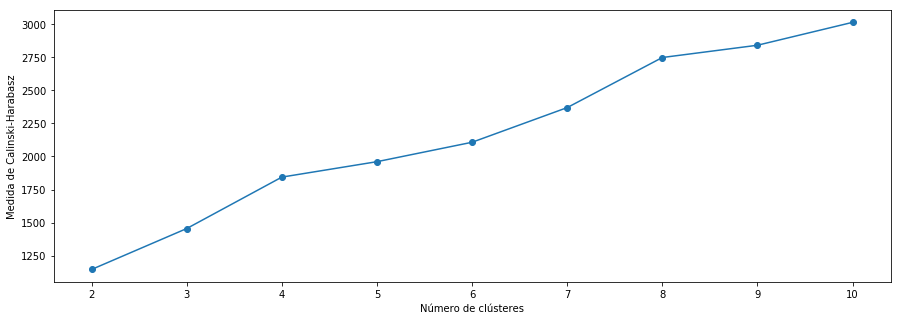

In [114]:
# Comprobación de número de clusters adecuados
rsilueta = np.zeros(9)
rcalinski = np.zeros(9)

# Asignación a la variable Dx
Dx = D

for k in np.arange(2,11):
    modelo = KMeans(n_clusters=k)
    modelo = modelo.fit(Dx)
    Dyp_sk = modelo.predict(Dx)
    cDx_sk = modelo.cluster_centers_
    rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
    rcalinski[k-2] = calinski_harabaz_score(Dx, Dyp_sk)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Medida de ancho de silueta")

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11), rcalinski, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Medida de Calinski-Harabasz")

In [115]:
from sklearn.metrics import silhouette_samples

# función para dibujar la silueta
def plot_silhouettes(X, y):
    cluster_labels = np.unique(y)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y, metric='euclidean')
    y_ax_lower = 0
    y_ax_upper = 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
#         color = cm.jet(i / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none'
        )
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color='red', linestyle='--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.show() 

Unicos  {0, 1, 2}
Silueta:  0.5851784233104742
Calinski Harabaz:  1454.5938219457792
[29.6517 4.03889 107.208 77.1667 2222.83 16.3344 76.7111 2.05556]
[14.6356 7.86667 344.144 157.811 4236.32 13.4633 74.0111 1.01111]
[20.7893 5.81967 212.615 105.402 3162.58 15.9041 76.3525 1.28689]

Unicos  {0, 1, 2, 3}
Silueta:  0.5785843947450602
Calinski Harabaz:  1843.8640917660518
[18.3528 6.64045 259.966 116.809 3484.48 15.6753 75.5843 1.11236]
[30.7368 3.97794 98.1287 72.9485 2107.71 16.6015 76.625 2.17647]
[13.9913 8 356.536 165.13 4366.59 13.042 73.6087 1]
[24.6102 4.70408 154.347 94.2959 2746.44 15.7082 77.1122 1.57143]

Unicos  {0, 1, 2, 3, 4}
Silueta:  0.5548894113504057
Calinski Harabaz:  1959.8808011465835
[30.7368 3.97794 98.1287 72.9485 2107.71 16.6015 76.625 2.17647]
[19.2014 6.3 240.971 108.214 3349.9 16.1743 75.8714 1.12857]
[24.8097 4.63441 151.237 94.3333 2728.98 15.6613 77.129 1.60215]
[13.339 8 374.585 177.293 4545.34 12.7341 72.8293 1]
[15.6212 7.76923 318.712 142.577 3959.96 13

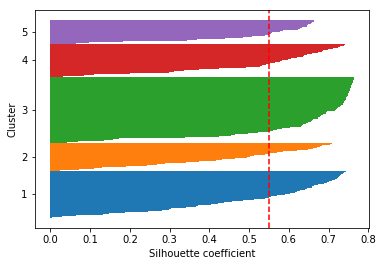

In [32]:
from sklearn.metrics import mutual_info_score, silhouette_score, calinski_harabaz_score

# Cambio la salida por consola de los números
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})

# Se inicializa KMeans con el número de clústeres a buscar
for nClusters in range(3,7):
    nCluster = nClusters
    modelo = KMeans(n_clusters=nClusters)
    # Se aprende el 
    modelo = modelo.fit(Dx)
    # Predicting the clusters
    Dyp_sk = modelo.predict(Dx)
    result = modelo.labels_
    # Obtener los centros de los clústeres
    cDx_sk = modelo.cluster_centers_
    
    print("Unicos ", set(result))
    cResult = [[Dx[x] for x in range(len(Dx)-1) if result[x]==i] for i in set(result)]
    print("Silueta: ", silhouette_score(Dx,result))
    print("Calinski Harabaz: ", calinski_harabaz_score(Dx, result))
#     print(columHeaders)
    for centro in cDx_sk:
        print(centro)
    print("")

modelo = KMeans(n_clusters=5)
# Se aprende el 
modelo = modelo.fit(Dx)
# Predicting the clusters
Dyp_sk = modelo.predict(Dx)
result = modelo.labels_
plot_silhouettes(Dx,result)

# Clustering Jerárquico Aglomerativo

SINGLE


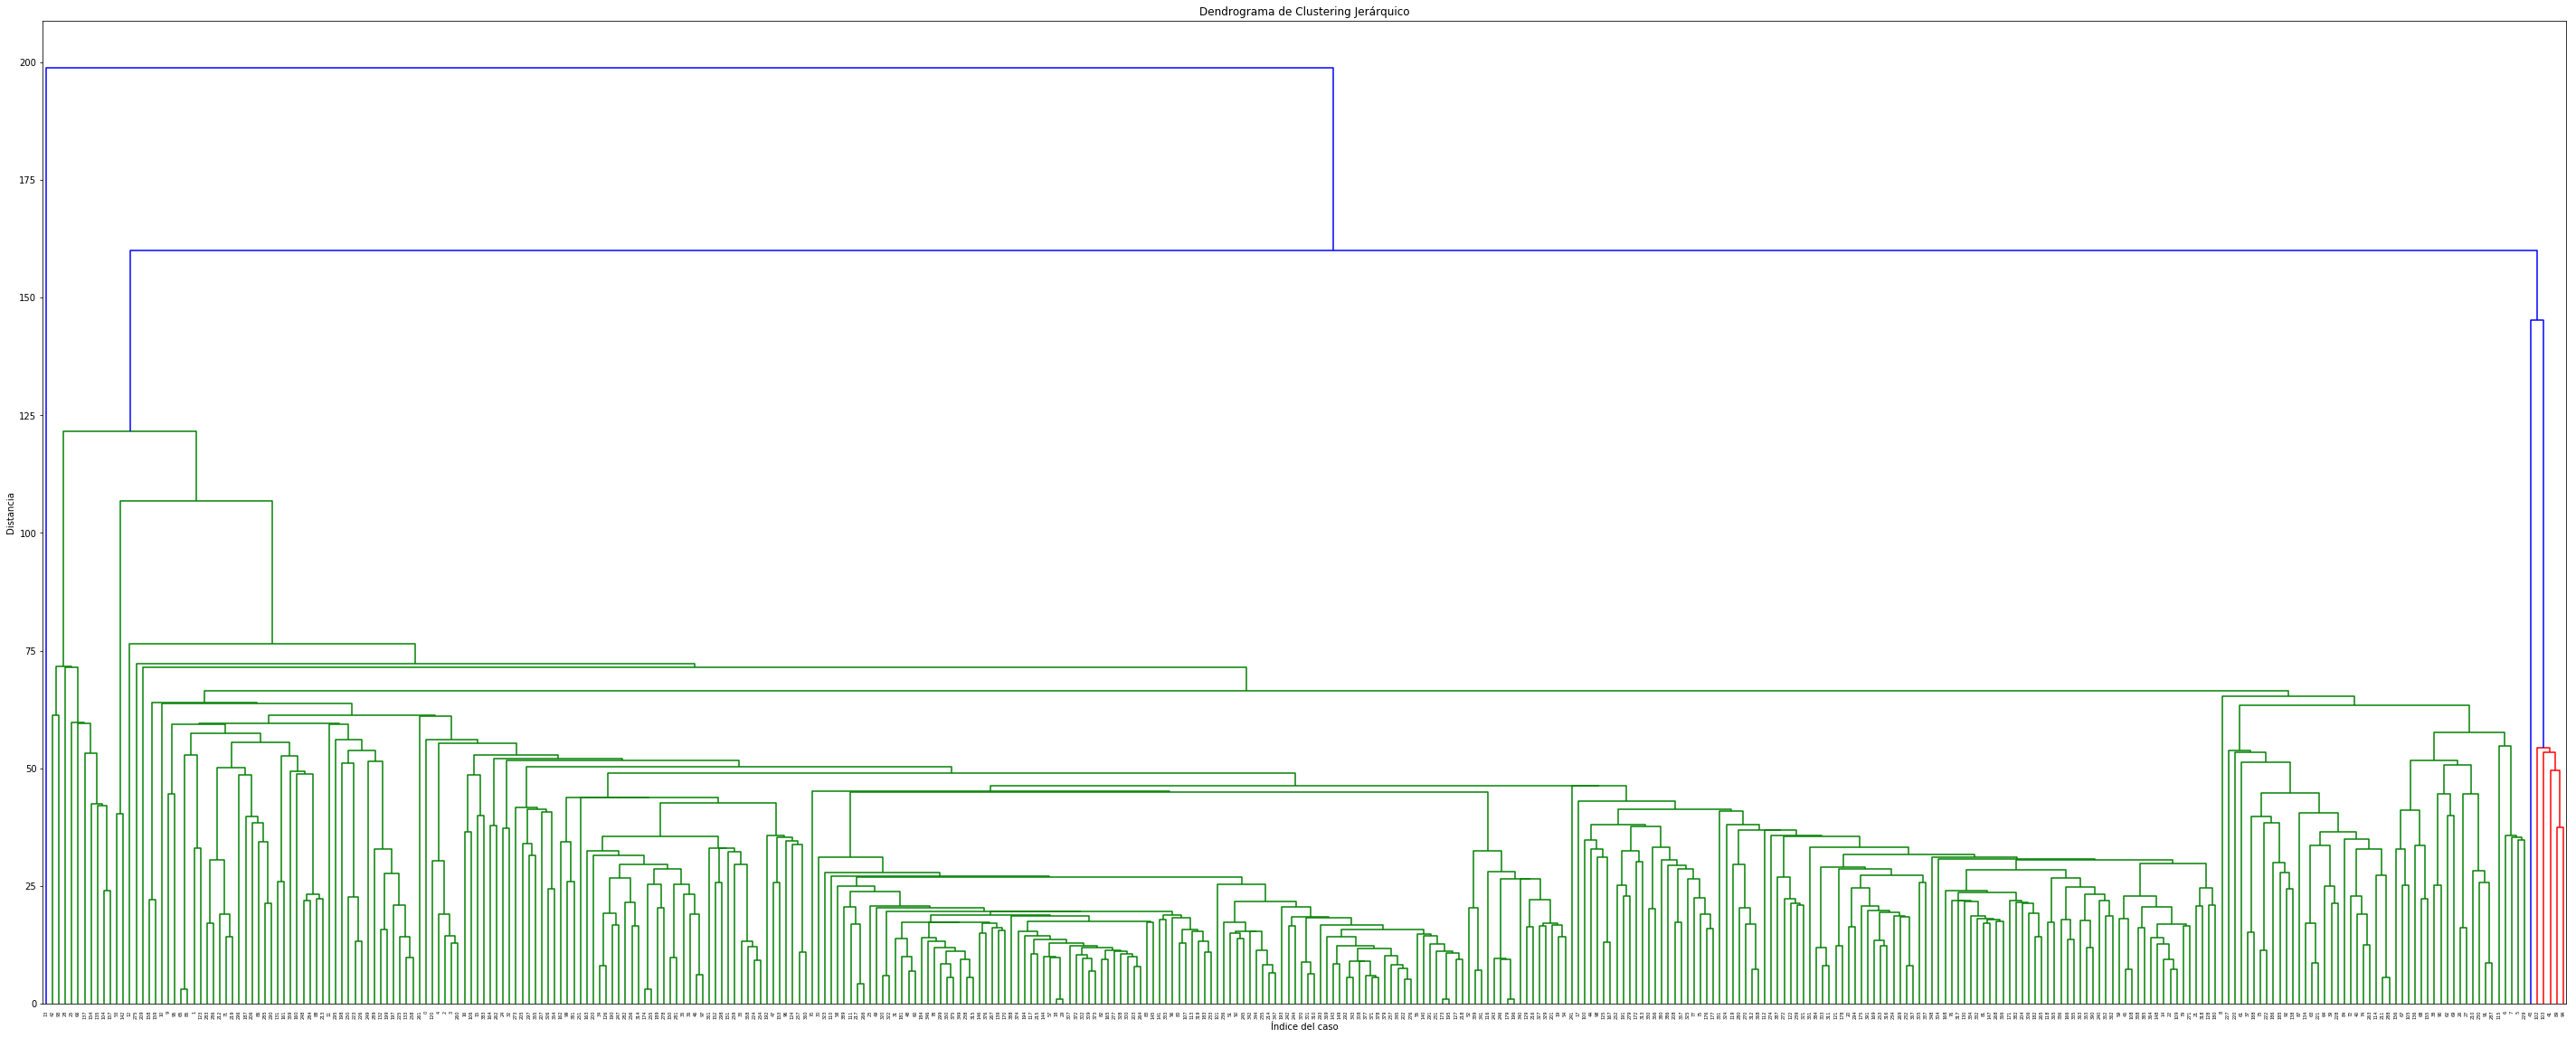

Unicos  {0, 1, 2}
Silueta:  -0.20745943945936626
Calinski Harabaz:  18.515817850534987
Unicos  {0, 1, 2, 3}
Silueta:  -0.21711823346353595
Calinski Harabaz:  12.328153804903335
Unicos  {0, 1, 2, 3, 4}
Silueta:  -0.1820283813535563
Calinski Harabaz:  23.533654037969352
COMPLETE


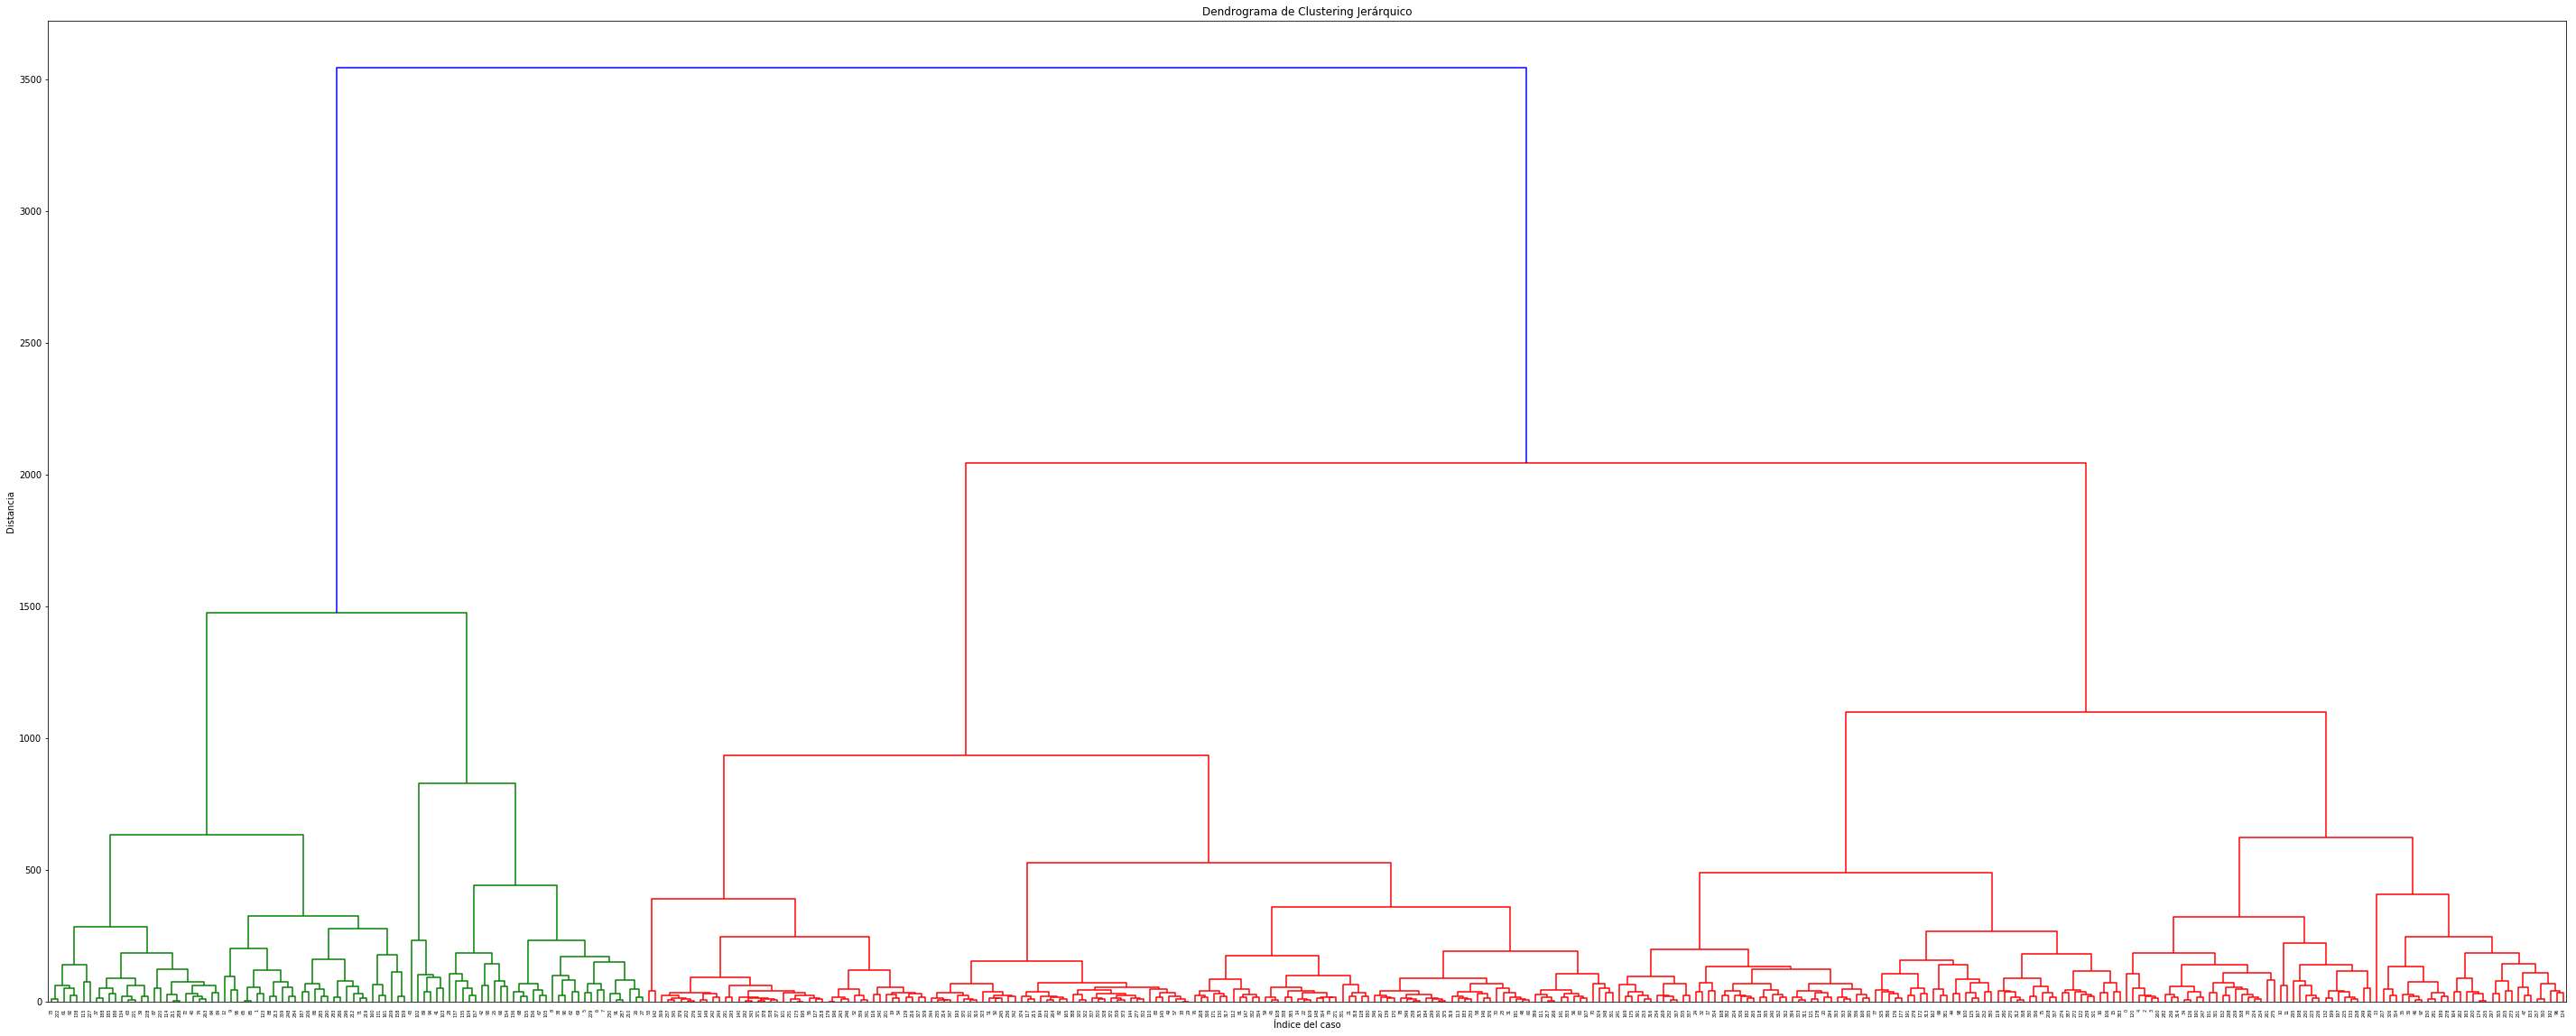

Unicos  {0, 1, 2}
Silueta:  0.5776309483287865
Calinski Harabaz:  1400.5536609773637
Unicos  {0, 1, 2, 3}
Silueta:  0.5229900255622141
Calinski Harabaz:  1238.7516285914712
Unicos  {0, 1, 2, 3, 4}
Silueta:  0.5379556825152667
Calinski Harabaz:  1804.4843697118542
AVERAGE


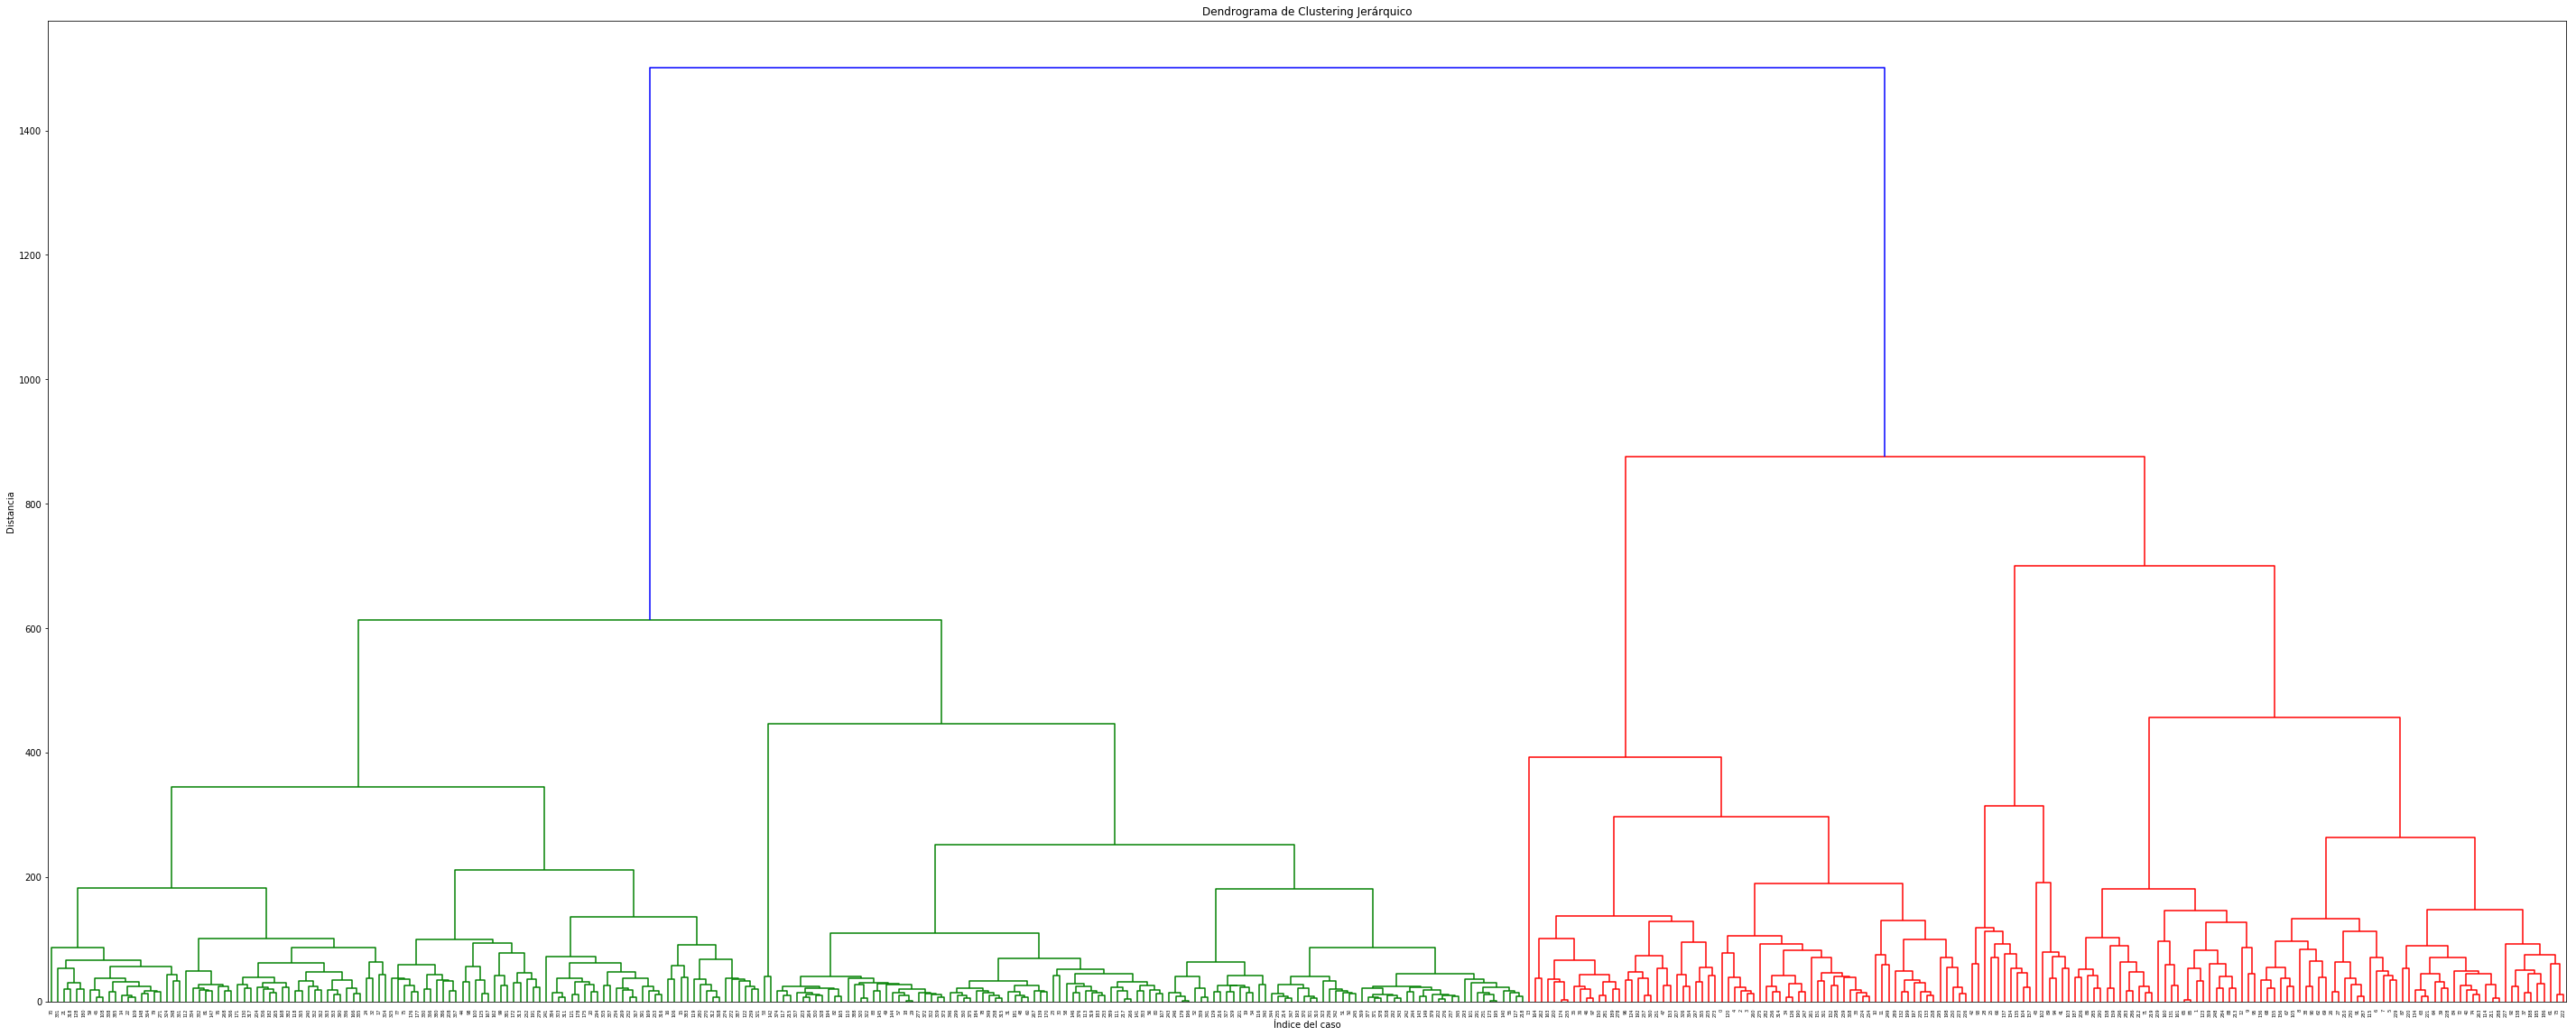

Unicos  {0, 1, 2}
Silueta:  0.5237095418664999
Calinski Harabaz:  1093.720535728798
Unicos  {0, 1, 2, 3}
Silueta:  0.5067071259464944
Calinski Harabaz:  876.1999809047844
Unicos  {0, 1, 2, 3, 4}
Silueta:  0.5328595880565226
Calinski Harabaz:  1711.2557864477324


In [116]:
from sklearn.cluster import AgglomerativeClustering

modelo_single = linkage(Dx, 'single')   # disimilitud mínima
modelo_completo = linkage(Dx, 'complete') # disimilitud máxima
modelo_average = linkage(Dx, 'average')  # disimilitud media


print("SINGLE")
plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_single)
plt.show()
for nClusters in range(3,6):
    result = cut_tree(modelo_single, n_clusters=nClusters).flatten()
    print("Unicos ", set(result))
    print("Silueta: ", silhouette_score(Dx,result))
    print("Calinski Harabaz: ", calinski_harabaz_score(Dx, result))


print("COMPLETE")
plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_completo)
plt.show()
for nClusters in range(3,6):
    result = cut_tree(modelo_completo, n_clusters=nClusters).flatten()
    print("Unicos ", set(result))
    print("Silueta: ", silhouette_score(Dx,result))
    print("Calinski Harabaz: ", calinski_harabaz_score(Dx, result))

    
print("AVERAGE")
plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_average)
plt.show()

for nClusters in range(3,6):
    result = cut_tree(modelo_average, n_clusters=nClusters).flatten()
    print("Unicos ", set(result))
    print("Silueta: ", silhouette_score(Dx,result))
    print("Calinski Harabaz: ", calinski_harabaz_score(Dx, result))

## AGRUPAMIENTO ESPECTRAL

Unicos  {0, 1, 2}
Silueta:  0.5409305650587414
Calinski Harabaz:  1198.7118294159604
Unicos  {0, 1, 2, 3}
Silueta:  0.4983891395598823
Calinski Harabaz:  1396.5565132424017
Unicos  {0, 1, 2, 3, 4}
Silueta:  0.5319273629721655
Calinski Harabaz:  1671.4035822993922


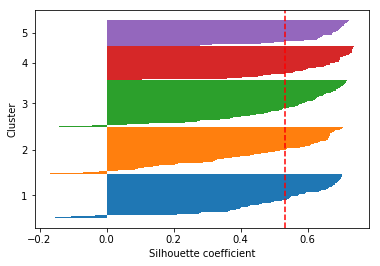

In [34]:
for nClusters in range(3,6):
    knn = 25 # No es capaz de resolver al probar distintos valores de knn
    clustering = SpectralClustering(n_clusters = nClusters, 
                                    affinity = 'nearest_neighbors', n_neighbors = knn,
                                    random_state = 0).fit(Dx)
    result = clustering.labels_
    
    print("Unicos ", set(result))
    print("Silueta: ", silhouette_score(Dx,result))
    print("Calinski Harabaz: ", calinski_harabaz_score(Dx, result))


clustering = SpectralClustering(n_clusters = nClusters, affinity = 'nearest_neighbors', n_neighbors = knn, random_state = 0).fit(Dx)
result = clustering.labels_    
plot_silhouettes(Dx,result)

# Agrupamiento basado en densidad - DBSCAN

In [35]:
solucionsD = []
for nSamples in range(2,10):
    for nEps in range (5,25):
        clustering = DBSCAN(eps=nEps, min_samples=nSamples).fit(Dx)
        result = clustering.labels_
        
#         print("nSamples: ", nSamples, " nEps: ", nEps, " Unicos ", set(result))
        if len(set(result)) <= 1:
#             print("Sin clusters \n")
            continue
#         print("Silueta: ", silhouette_score(Dx,result))
#         print("Calinski Harabaz: ", calinski_harabaz_score(Dx, result))
#         print("")
        solucionsD.append([nSamples,nEps,len(set(result)),silhouette_score(Dx,result),calinski_harabaz_score(Dx, result)])

df = pd.DataFrame(solucionsD,columns=['nSamples', 'nEps', 'clusters', 'silhoutte', 'calinski'])

df   

,nSamples,nEps,clusters,silhoutte,calinski
0,2,5,7,-0.701072,1.979462
1,2,6,13,-0.699398,2.347768
2,2,7,19,-0.649961,2.399786
3,2,8,24,-0.662458,2.426607
4,2,9,30,-0.634452,2.751032
5,2,10,34,-0.573364,3.135129
6,2,11,35,-0.544984,3.473342
7,2,12,34,-0.518944,4.258252
8,2,13,37,-0.469290,4.390673
9,2,14,40,-0.410628,4.492500


# Agrupamiento basado en densidad - Mean Shift

In [38]:
solucionsD = []
for nBandwidth in range(95,300,10):
    clustering = MeanShift(bandwidth = nBandwidth).fit(Dx)
    
    result = clustering.labels_
    solucionsD.append([nBandwidth,len(set(result)),silhouette_score(Dx,result),calinski_harabaz_score(Dx, result)])

df = pd.DataFrame(solucionsD,columns=['nBandwidth', 'clusters', 'silhoutte', 'calinski'])
df

,nBandwidth,clusters,silhoutte,calinski
0,95,23,0.434205,3682.157988
1,105,21,0.437782,3573.584538
2,115,17,0.465261,3315.999061
3,125,15,0.481031,2837.837456
4,135,15,0.443948,1757.829700
5,145,13,0.444235,1809.162925
6,155,13,0.423668,1866.958256
7,165,11,0.458522,1811.958258
8,175,10,0.451859,1794.825194
9,185,10,0.452887,1717.948582


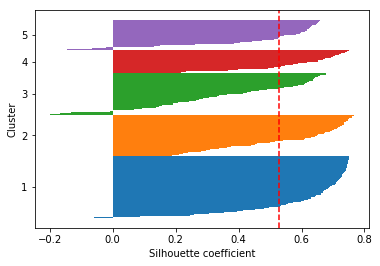

In [37]:
clustering = MeanShift(bandwidth = 295).fit(Dx)
result = clustering.labels_

    
plot_silhouettes(Dx,result)    